# Benchmark QC

Benchmark different single cell ATAC-seq QC approaches. 
H5ad files should be preprocessed and the anndata.obs table should contain the qc-columns to filter on. Preprocessing is archived by executing preprocessing.ipynb. 

QC metrices tested:

    - TSSe
    - FRiP
    - Fragment count
    - Feature count
    - Doublets
    - Mito/Nuclei DNA
    - PEAKQC
    - Nucleosome score (muon)
    
 Embedding and filtering quality metrices to evaluate effects:
 
    - Residual Average Gini Index (RAGI)
    - Adjusted Rand Index (ARI)
    - Editing Distance Score (EDS)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
import upsetplot
import matplotlib
from tqdm import tqdm
from multiprocessing import Pool, Manager
from functools import partial
from collections import OrderedDict
import time

import peakqc.insertsizes as ins
import peakqc.fld_scoring as fld

# type hint imports
from beartype.typing import Tuple, Dict, Optional, Literal, Callable, Iterable, Any  # , Union, List
import numpy.typing as npt

In [2]:
def density_plot(count_table: npt.ArrayLike,
                 max_abundance: int = 600,
                 target_height: int = 1000,
                 save: Optional[str] = None,
                 title: Optional[str] = 'Fragment Length Density Plot',
                 colormap: str = 'jet',
                 ax: Optional[matplotlib.axes.Axes] = None,
                 fig: Optional[matplotlib.figure.Figure] = None) -> npt.ArrayLike:
    """
    Plot the density of the fragment length distribution over all cells.

    The density is calculated by binning the abundances of the fragment lengths.

    Parameters
    ----------
    count_table : npt.ArrayLike
        Array of arrays of the fragment length distributions
    max_abundance : int, default 600
        Maximal abundance of a fragment length of a cell (for better visability)
    target_height : int, default 1000
        Target height of the plot
    save : Optional[str], default None
        If true, the figure is saved under the given name.
    colormap : str, default 'jet'
        Color map of the plot.
    ax : matplotlib.axes.Axes, default None
        Axes to plot on.
    fig : matplotlib.figure.Figure, default None
        Figure to plot on.

    Returns
    -------
    npt.ArrayLike
        Axes and figure of the plot.
    """
    count_table = count_table
    # handle 0,1 min/max scaled count_table
    if count_table.dtype != 'int64':
        if np.max(count_table) > 1:
            rounded = (np.round(count_table)).astype('int64')
            count_table = rounded
        else:
            count_table = (count_table * 1000).astype('int64')
    # get the maximal abundance of a fragment length over all cells
    max_value = np.max(np.around(count_table).astype(int))
    # Init empty densities list
    densities = []
    # loop over all fragment lengths from 0 to 1000
    for i in range(0, len(count_table[0])):
        column = count_table[:, i]
        # round abundances to be integers, that they are countable
        rounded = np.around(column).astype(int)
        # count the abundance of the abundances with boundaries 0 to maximal abundance
        gradient = np.bincount(rounded, minlength=max_value + 1)
        densities.append(gradient)
    densities = np.array(densities)

    # Log normalization + 1 to avoid log(0)
    densities_log = np.log1p(densities)

    # Transpose the matrix
    densities = densities_log.T

    # get the section of interest
    densities = densities[:max_abundance]

    # calculate the mean of the FLD
    mean = count_table.sum(axis=0) / len(count_table)

    # Stretch or compress densities' y-axis to the target height
    num_rows = densities.shape[0]
    old_y = np.linspace(0, num_rows - 1, num_rows)
    new_y = np.linspace(0, num_rows - 1, 1000)

    # Interpolate the densities along the y-axis
    densities_interpolated = np.array([np.interp(new_y, old_y, densities[:, i]) for i in range(densities.shape[1])]).T

    # scaling factor for mean
    scaling_factor = len(new_y) / len(old_y)

    # Apply the scaling factor to the mean values
    mean_interpolated = mean * scaling_factor

    # Initialize subplots
    if ax is None:
        main_plot = True
        fig, ax = plt.subplots()
    else:
        main_plot = False

    # Display the image
    im = ax.imshow(densities_interpolated, aspect='auto', origin="lower", cmap=colormap)

    # Plot additional data
    ax.plot(mean_interpolated, color="red", markersize=1)

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel('Fragment Length', color='blue')
    ax.set_ylabel('Number of Fragments', color='blue')

    # Adjust y-ticks to show original scale
    ax.set_yticks(np.linspace(0, target_height - 1, 6))
    ax.set_yticklabels(np.linspace(0, num_rows - 1, 6).astype(int))

    # Add colorbar to the plot
    if fig is not None:
        fig.colorbar(im, ax=ax, label='Density (log scale)')

    if main_plot:
        if save:
            plt.savefig(save)

        plt.show()

    figure = np.array([ax, fig])

    return figure

In [3]:
def _upset_select_cells(adata: sc.AnnData,
                        thresholds: dict[str, dict[str, dict[Literal["min", "max"], int | float]] | dict[
                            Literal["min", "max"], int | float]],
                        groupby: Optional[str] = None,
                        direction: Literal['passed', 'filtered'] = 'passed') -> pd.DataFrame:
    """
    Select cells based on thresholds for UpSet Plot.

    Parameters
    ----------
    adata : sc.AnnData
        Annotated data matrix object.
    thresholds : dict[str, dict[str, dict[Literal["min", "max"], int | float]] | dict[Literal["min", "max"], int | float]]
        Dictionary containing thresholds for each column. If groupby is given, thresholds are set per group.
    groupby : Optional[str], default None
        Name of the column in adata.obs to group cells by.

    Returns
    -------
    selection : pd.DataFrame
        DataFrame containing boolean values for each cell based on thresholds.
    """
    selection = {}
    # loop over all columns
    for column_name, values in thresholds.items():
        # loop over all groups
        if groupby:
            # initialize an array of False values
            accumulate_results = np.zeros(adata.obs.shape[0], dtype=bool)
            # loop over all samples
            for sample, cutoffs in values.items():
                # select cells based on the sample
                sample_selection = np.array(adata.obs[groupby] == sample)
                # select cells based on the cutoffs
                if direction == 'filtered':
                    cutoff_selection = np.array(
                        (adata.obs[column_name] < cutoffs['min']) | (adata.obs[column_name] > cutoffs['max']))
                elif direction == 'passed':
                    cutoff_selection = np.array(
                        (adata.obs[column_name] > cutoffs['min']) & (adata.obs[column_name] < cutoffs['max']))
                else:
                    # TODO add proper error handling
                    print('Error')

                # add up the selected cells
                accumulate_results = accumulate_results + np.logical_and(sample_selection, cutoff_selection)
            # add the results to the selection
            accumulate_series = pd.Series(accumulate_results, index=adata.obs.index)
            selection[column_name] = accumulate_series

        else:
            # select cells based on the cutoffs
            if direction == 'filtered':
                selection[column_name] = (adata.obs[column_name] < values['min']) | (
                            adata.obs[column_name] > values['max'])
            elif direction == 'passed':
                selection[column_name] = (adata.obs[column_name] > values['min']) & (
                            adata.obs[column_name] < values['max'])
            else:
                # TODO add proper error handling
                print('Error')

    # convert to DataFrame
    selection = pd.DataFrame(selection)

    return selection


def upset_plot_filter_impacts(adata: sc.AnnData,
                              thresholds: dict[str, dict[str, dict[Literal["min", "max"]]]],
                              limit_combinations: Optional[int] = None,
                              groupby: Optional[int] = None,
                              direction: Literal['passed', 'filtered'] = 'passed',
                              log: Optional[bool] = False) -> Optional[dict]:
    """
    Plot the impact of filtering cells based on thresholds in an UpSet Plot.

    Parameters
    ----------
    adata : sc.AnnData
        Annotated data matrix object.
    thresholds : dict[str, dict[str, dict[Literal["min", "max"], int | float]] | dict[Literal["min", "max"], int | float]]
        Dictionary containing thresholds for each column. If groupby is given, thresholds are set per group.
    limit_combinations : Optional[int], default None
        Limit the number of combinations to show in the plot.
    groupby : Optional[str], default None
        Name of the column in adata.obs to group cells by.

    Returns
    -------
    plot_result : Optional[dict]
    """
    if len(thresholds) <= 1:
        logger.info("Skipping UpSet Plot as only one threshold is given.")

        return None

    selection = _upset_select_cells(adata, thresholds, groupby, direction)

    # Number of variables
    n = len(selection.columns)

    # Generate all combinations of True/False
    raw_combinations = np.array(np.meshgrid(*[[False, True]] * n)).T.reshape(-1, n)

    # Sort the combinations first by the number of True values, then lexicographically
    sorted_combinations = np.array(sorted(raw_combinations, key=lambda x: (np.sum(x), list(x))))

    # exclude empty combinations
    mask = np.sum(sorted_combinations, axis=1) != 0
    combinations = sorted_combinations[mask]

    # make a dataframe
    combinations_df = pd.DataFrame(combinations, columns=selection.columns)

    counts = []
    barcodes = []

    # loop over all combinations
    for _, combination in combinations_df.iterrows():
        # get a list of the column names selected
        metric_combination = list(selection.columns[combination])
        # initialize a results array for the combination with len n-cells
        single_result = np.zeros(selection.shape[0], dtype=bool)
        # loop over the selected combination
        for metric in metric_combination:
            # check if initialized
            if sum(single_result) == 0:
                single_result = selection[metric]
            else:
                # add up the selected cells
                if direction == 'filtered':
                    single_result = np.logical_or(single_result, selection[metric])
                elif direction == 'passed':
                    single_result = np.logical_and(single_result, selection[metric])

        # append result of the combination
        counts.append(sum(single_result))
        # append the barcodes of the cells
        barcodes.append(single_result.iloc[single_result.values].index)
    # add to dataframe
    combinations_df['counts'] = counts
    combinations_df['barcodes'] = barcodes

    # limit combinations
    if limit_combinations:
        # select all combinations with a grade less or equal the limit
        limit_mask = np.array(np.sum(combinations_df[selection.columns], axis=1) <= limit_combinations)
        # always include the total counts
        limit_mask[-1] = True
        # index by the mask
        combinations_df = combinations_df[limit_mask]

    # set the combinations as index
    combinations_df.set_index(list(selection.columns), inplace=True)

    if log:
        combinations_df['counts'] = np.log(combinations_df['counts'])

    with warnings.catch_warnings():  # TODO remove when this is merged https://github.com/jnothman/UpSetPlot/pull/278
        warnings.filterwarnings("ignore",
                                message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")

        # plot the UpSet Plot
        plot_result = upsetplot.plot(combinations_df['counts'], totals_plot_elements=0)

    if direction == 'filtered':
        plot_result["intersections"].set_ylabel("Cells Filtered")
    elif direction == 'passed':
        plot_result["intersections"].set_ylabel("Cells Passed")
    plt.show()

    return plot_result, combinations_df

In [4]:
"""HELPER FUNCTIONS."""
# Author: Jan Detleffsen (jan.detleffsen@mpi-bn.mpg.de)

def calculate_distances(adata, neighbours, cell_idx, highly_variable=False):
    """
    Calculate edited distances of the available features between a cell and its neighbours.
    The distance is normalized by the total counts of the features.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    neighbours : np.array
        Array of indices of the neighbours.
    cell_idx : int
        Index of the cell.

    Returns
    -------
    float
        Mean of the normalized distances.
    """
    
    # calculate the distances of the features between the cell and its neighbours
    # if the number of neighbours is larger than 0
    if len(neighbours) > 0:
        if highly_variable:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours][:, adata.var.highly_variable], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx][:, adata.var.highly_variable])
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours][:, adata.var.highly_variable] - adata.X[cell_idx][:, adata.var.highly_variable].toarray()[0]), axis=1)
            # change distance when there no highly variable features to 1
            zeros = np.where(total_counts == 0)
            # set the distances to 1
            distances[zeros] = 1
            # set the total counts to 1
            total_counts[zeros] = 1

        else:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx].toarray(), axis=1)[0]
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours] - adata.X[cell_idx].toarray()[0]), axis=1)

        # normalize the distances by the total counts
        corrected_distances = distances / total_counts
        # calculate the mean of the normalized distances
        distance = np.mean(corrected_distances)
    # if there are no neighbours, set the distance to 1
    else:
        distance = 1

    return distance


def define_reference_cells(embedding, cell_idx, distance=False, n_cells=20):
    """
    Define the neighbours of a cell based on the Euclidean distance in the embedding space.

    Parameters
    ----------
    embedding : np.array
        Array of the embedding coordinates.
    cell_idx : int
        Index of the cell.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.

    Returns
    -------
    np.array
        Array of indices of the neighbours.
    """
    # extract the embedding coordinates of the cell
    cell_coordinates = embedding[cell_idx]
    # calculate the relative coordinates of the cell to all other cells
    relative_coordinates = embedding - cell_coordinates
    # calculate the distances of the cells to the cell
    distances = np.linalg.norm(relative_coordinates, axis=1)
    # find the indices of the cells that are closer than the distance
    if distance:
        # define the neighbours based on the distance
        indices_neighbours = np.array(np.where(distances <= distance))
        # define number of cells tom select
        n_cells = len(indices_neighbours)
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):]
    else:
        # define the neighbours based on the number of cells to consider
        indices_neighbours = np.argsort(distances)[:n_cells]
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):] # -1 to correct for seeding cell
    # remove the cell itself from the indices
    neighbours = indices_neighbours[np.where(indices_neighbours != cell_idx)]

    return neighbours, foreigners


def add_similarity(adata, distance=False, n_cells=20, embedding=None, threads=1, chunksize=50, highly_variable=False):
    """
    Add the similarity of the cells to the AnnData object.

    The similarity is calculated as the mean of the normalized distances of the available features between a cell and its neighbours.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    embedding : str, optional
        Key of the embedding coordinates in adata.obsm. If None, the UMAP coordinates are used. Default is None.
    threads : int, optional
        Number of threads to use for the calculation. Default is 1.
    chunksize : int, optional
        Number of cells to process in one chunk. Default is 50.

    Returns
    -------
    None
    """
    # extract the embedding coordinates
    if embedding is None:
        coordinates = adata.obsm['X_umap']
    else:
        coordinates = adata.obsm[embedding]

    # check if highly variable features are available
    if 'highly_variable' not in adata.var.keys():
        highly_variable = False

    # initialize the Pool with the number of threads and the maximum number of tasks per child
    pool = Pool(processes=threads, maxtasksperchild=threads)
    # initialize a Manager to share the results between the processes
    manager = Manager()
    # initialize a dictionary to store the similarities
    similarities = manager.dict()

    # initialize a list to store the results of the processes
    async_results = []
    # initialize a list to build the chunks
    chunk = []

    # Calculate total number of chunks for progress bar
    total_chunks = (len(coordinates) + chunksize - 1) // chunksize  # rounds up
    pbar = tqdm(total=total_chunks, desc="Computing chunks")

    # iterate over the cells in the embedding
    for cell_idx, cell_coordinates in enumerate(coordinates):
        # append the cell index and the embedding coordinates to the chunk
        chunk.append([cell_idx, cell_coordinates])
        # if the chunk is full
        if len(chunk) == chunksize:
            # process the chunk
            result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                      callback=partial(collect_result, similarities))
            # append the result to the list
            async_results.append(result)
            # clear the chunk
            chunk = []
            # update the progress bar
            pbar.update(1)
            # check if the number of running processes is larger than the number of threads
            while len(async_results) > 2 * threads:  # Adjust this ratio based on observed behavior and system specs
                # remove the finished processes
                async_results = [res for res in async_results if not res.ready()]
                # sleep for 1 second
                time.sleep(1)

    # remaining
    if len(chunk) != 0:
        result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                  callback=partial(collect_result, similarities))
        async_results.append(result)
        pbar.update(1)

    for result in async_results:
        result.wait()

    pool.close()
    pool.join()

    similarities = dict(similarities)

    sorted_similarities = OrderedDict(sorted(similarities.items()))

    adata.obs['distance_score'] = np.fromiter(sorted_similarities.values(), dtype=float)


def collect_result(similarities, result):
    similarities.update(result)


def process_chunk(chunk, distance, n_cells, adata, coordinates, highly_variable=False):
    """
    process a chunk of cells to calculate the distance_score of the cells to their neighbours

    Parameters
    ----------
    chunk : list
        List of the cell indices and the embedding coordinates.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    adata : AnnData
        Annotated data matrix.
    coordinates : np.array
        Array of the embedding coordinates.

    Returns
    -------
    dict
        Dictionary of the similarities.

    """
    sim_dict = {}
    for cell_idx, cell_coordinates in chunk:
        # define the reference cells
        neighbours, foreigners = define_reference_cells(coordinates, cell_idx, distance, n_cells)
        # calculate the distances of the features between the cell and its neighbours
        distance_n = calculate_distances(adata, neighbours, cell_idx, highly_variable=highly_variable)
        # calculate the distances of the features between the cell and the most distant cells
        distance_f = calculate_distances(adata, foreigners, cell_idx, highly_variable=highly_variable)
        # calculate the distance based score of the cell
        sim_dict[cell_idx] = 1/(distance_f+1) + distance_n

    return sim_dict


#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))


def calc_agi(adata, condition_column='cell_types_leiden_0.4'):
    
    adata_copy = adata.copy()
    conditions = adata_copy.obs[condition_column].unique()
    enrichment_columns = []

    for cond in conditions:

        # slice by cluster 
        adata_slice = adata_copy.obs_names[adata_copy.obs[condition_column] == str(cond)]
        subdata = adata_copy[adata_slice, :]
        # select all peaks available in the cluster 
        genes = subdata.var[subdata.layers['binary'].sum(axis=0).A1 > 1]
        # count abundances
        gene_counts = subdata.layers['binary'].sum(axis=0).A1[subdata.layers['binary'].sum(axis=0).A1 > 1]
        genes.loc[:, 'cluster_counts_' + str(cond)] = gene_counts
        # calc enrichment 
        genes['enrichment_' + str(cond)] = genes['cluster_counts_' + str(cond)] / genes['total_counts']
        # remove old tables
        # join results
        adata_copy.var = adata_copy.var.join(genes['cluster_counts_' + str(cond)])
        adata_copy.var = adata_copy.var.join(genes['enrichment_' + str(cond)])

        enrichment_columns.append('enrichment_' + str(cond))

    enrichments = adata_copy.var[enrichment_columns].values
    enrichments[np.isnan(enrichments)] = 0

    gini_coefficients = []
    for enrichment in enrichments:
        gini_coefficients.append(gini(enrichment))

    adata_copy.var[condition_column + '_' + 'gini'] = gini_coefficients

    return adata_copy

In [5]:
# Imports
import sctoolbox
import sctoolbox.tools.qc_filter as qc
import sctoolbox.utils as utils
import sctoolbox.tools as tools
import sctoolbox.plotting as pl

import matplotlib.pyplot as plt
import episcanpy as epi
import pandas as pd
import scrublet as scr
import os
import numpy as np
import scanpy as sc

In [6]:
# Sample
sample = 'right_atrium_auricular_region_IOBHN'

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

# Absolute minimum number of features for pre-selection of cells before QC 
min_genes = 1

# Choose whether to binarize the X matrix
binarize_mtx = False  # True or False; convert matrix to binary

#----------------------- Doublet removal ------------------------

# filter doublets
remove_doublets = False

# Use native scrublet or the scanpy wrapper (scanpy: optimized for RNA)
use_native_scrublet = True

# Default threshold to apply doublet removal on (None for automatic threshold)
doublet_threshold = None # 0.2
# Available threads
threads = 8

# Set default filter thresholds
# This will be applied to all samples - the thresholds can be changed manually when plotted 
use_default_thresholds = True  # set to False to ignore default_thresholds
thresholds = {
              'n_features': {'min': 150, 'max': 5000},
              #'log1p_n_features': {'min': None, 'max': None},
              'nucleosome_signal': {'min': 0.1, 'max': 0.7},
              'fld_score': {'min': 100, 'max': 5000},
              'frip': {'min': 0.1, 'max': 2}
              #'tsse_score': {'min': 2, 'max': 1000}
              # add additional threshold based on the available columns shown above
              # format: '<obs clolumn>': {'min': <threshold|None>, 'max': <threshold|None>}
             }

limit_combinations=2

# Removal of feature subsets
filter_chrM = True  # True or False; filtering out chrM
filter_xy = True    # True or False; filtering out chrX and chrY

# Highly Variable Features options 
select_highly_variable = True
min_cells = 5 # This one is mandatory
max_cells = None

# Choose normalization method
# TF-IDF: dimensionality is reduced by LSI
# Total: dimensionality is reduced by PCA 
norm_method = 'tfidf'  # can be 'tfidf' or 'total'

# Choose if highly variable features should be used
use_highly_variable = True

# Set number of neighbors
n_neighbors = 15

# UMAP related settings 
metacol = 'sample'  # some meta-column of interest. See tables above.
n_features = 'n_features'  # column name for the number of features. See tables above.

# number of PCs shown within the heatmap
n_pcs_heatmap = 15

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.7  # PCs with an absolut correlation above this will be filtered
perc_thresh = 30 # Top percentile of PCs that should be kept
filter_methods = ['cumulative variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var
ignore_cols = []  # List of column names to ignore for correlation

# Search embedding parameters
embedding = "umap"  # umap or tsne
search_parameters = True

n_components = 2  # Number of components for umap (>=3 enables 3d UMAP but likely degrades 2d results)

dist_range = (0.1, 0.31, 0.1)  # Set min_dist range for umap
spread_range = (1, 2.5, 0.5)  # Set spread range for umap

perplexity_range = (30, 60, 10)  # perplexity range for tsne
learning_rate_range = (400, 1000, 200)  # learning_rate for tsne

# Search different clustering resolutions
search_clustering_parameters = True
cluster_res_range = (0.1, 1, 0.1)  # Set the searched resolution range from low to high resolution (less to more clusters).
clustering_method = "leiden"  # leiden or louvain
cluster_ncols = 3  # Number of columns displayed in the plot

# Annotate regions to genes
GTF_PATH = '/mnt/flatfiles/organisms/new_organism/homo_sapiens/104/homo_sapiens.104.genes.gtf'  # genes gtf file
fragments = f'/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/fragments/fragments_right_atrium_auricular_region_IOBHN.bed'


## 3 - Load anndata
Uses the anndata object written by the previous notebook.

In [7]:
work_dir = os.getcwd()

h5ad_path, current_dir = os.path.split(work_dir)

while current_dir != 'benchmarking':
    h5ad_path, current_dir = os.path.split(h5ad_path)
    
h5ad_path = os.path.join(h5ad_path, current_dir)
h5ad_path = os.path.join(h5ad_path, 'assembled')
# h5ad_path = os.path.join(h5ad_path, 'processed_anndata')
h5ad_path = os.path.join(h5ad_path, f'{sample}.h5ad')

adata = utils.adata.load_h5ad(h5ad_path)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: /mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/assembled/right_atrium_auricular_region_IOBHN.h5ad


AnnData object with n_obs × n_vars = 73582 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'files', 'sctoolbox'

,TN,UM,PP,UQ,CM,file,sample,nucleosome_signal,fld_score,mean_fragment_size,n_fragments,fold_change_promoters_fragments,frip,tsse_score,catlas_ov,cell type
barcode,,,,,,,,,,,,,,,,
AAACTACCAGAAACCCGAGATA,28.0,21.0,21.0,21.0,1.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,1.000000,0.003301,117.23,13.0,0.076923,0.384615,1.000000,False,NaN
AAACTACCAGAAACCTAAGTGG,7116.0,6025.0,6011.0,6011.0,218.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.434524,305.939935,132.91,5861.0,0.163795,0.112779,1.513383,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTGCCGGAAGG,5.0,5.0,5.0,5.0,0.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,1.000000,0.053747,135.67,3.0,0.000000,0.333333,0.000000,False,NaN
TTCCATCCTCTTTGTGTTACCG,629.0,518.0,517.0,517.0,39.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.294118,40.761008,137.91,487.0,0.349076,0.336756,5.337278,False,NaN


,peak_chr,peak_start,peak_end
name,,,
chr1:10007-10565,chr1,10007,10565
chr1:11182-11364,chr1,11182,11364
...,...,...,...
chrY:56870833-56870955,chrY,56870833,56870955
chrY:56886632-56886906,chrY,56886632,56886906


In [8]:
# Ensure that condition column is a category
adata.obs[condition_column] = adata.obs[condition_column].astype("category")

### 4.2 - Remove empty cells and features

In [9]:
print('original shape:')
print(adata.shape)
print('Removing empty features and cells...')

adata = adata[adata.X.sum(axis=1) > 0]
adata = adata[:, adata.X.sum(axis=0) > 0]

print('new shape:')
print(adata.shape)

original shape:
(73582, 105042)
Removing empty features and cells...
new shape:
(69471, 101651)


### 4.4 - Binarize matrix
Binarizes the count matrix to be either 0 or 1. This corresponds to the general view that chromatin is either accessible (1) or inaccesible (0). However, it is still under debate whether binarization may result in a loss of information. Therefore,  binarization is optional.

**DOI: [10.1038/s41592-023-02112-6](https://doi.org/10.1038/s41592-023-02112-6)**

In [10]:
# save raw matrix
adata.layers["raw"] = adata.X.copy()
# binarize
if binarize_mtx:
    print("binarizing...")
    epi.pp.binarize(adata)
    # unique_values = np.unique(np.round(np.array(adata.X.todense()),2))
    print(f"unique values: {unique_values}")

### 4.5 Calculate and remove doublets
Doublets are artifacts where two (doublet) or more (multiplet) cells receive the same barcode. As multiplets behave as a joined feature set of the collected cells they may show up as a separate group in downstream analysis, thus potentially skewing results. Therefore, it is recommended to remove doublets.

**DOI: [10.1016/j.cels.2018.11.005](https://doi.org/10.1016/j.cels.2018.11.005)**

In [11]:
if remove_doublets:
    tools.qc_filter.estimate_doublets(adata, 
                                      use_native=use_native_scrublet, 
                                      groupby=condition_column, 
                                      threads=threads, 
                                      threshold=doublet_threshold)

In [12]:
if remove_doublets:
    # Remove the duplicates from adata
    tools.qc_filter.filter_cells(adata, "predicted_doublet", name="doublet")

In [13]:
# remove empty features
adata = adata[adata.X.sum(axis=1) > 0]
adata = adata[:, adata.X.sum(axis=0) > 0]

### 4.6 - Cell filtering
<hr style="border:1px solid black"> </hr>

Identify low quality cells and remove them from the dataset. Low quality cells are investigated using several metrics, which can be choosen below.

In [14]:
# Recalculate standard QC metrics (counts...)
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

# Remove peaks with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

In [15]:
# available obs columns
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata.obs)

,TN,UM,PP,UQ,CM,file,sample,nucleosome_signal,fld_score,mean_fragment_size,n_fragments,fold_change_promoters_fragments,frip,tsse_score,catlas_ov,cell type,n_features,log1p_n_features
barcode,,,,,,,,,,,,,,,,,,
AAACTACCAGAAACCCGAGATA,28.0,21.0,21.0,21.0,1.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,1.000000,0.003301,117.23,13.0,0.076923,0.384615,1.000000,False,NaN,8,2.197225
AAACTACCAGAAACCTAAGTGG,7116.0,6025.0,6011.0,6011.0,218.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.434524,305.939935,132.91,5861.0,0.163795,0.112779,1.513383,False,NaN,482,6.180017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTGCCGGAAGG,5.0,5.0,5.0,5.0,0.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,1.000000,0.053747,135.67,3.0,0.000000,0.333333,0.000000,False,NaN,1,0.693147
TTCCATCCTCTTTGTGTTACCG,629.0,518.0,517.0,517.0,39.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.294118,40.761008,137.91,487.0,0.349076,0.336756,5.337278,False,NaN,155,5.049856


In [16]:
obs_columns = list(thresholds.keys())

groupby = condition_column if global_threshold is False else None
initial_thresholds = tools.qc_filter.get_thresholds(adata,
                                                    thresholds, 
                                                    groupby=groupby)
tools.qc_filter.thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,n_features,150.0,5000.0
1,nucleosome_signal,0.1,0.7
2,fld_score,100.0,5000.0
3,frip,0.1,2.0


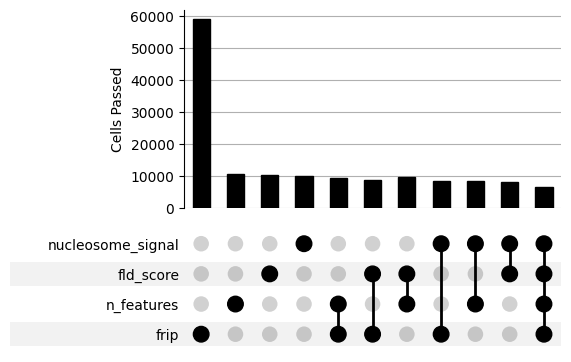

In [17]:
_, combinations_df = upset_plot_filter_impacts(adata, 
                                               thresholds=initial_thresholds, 
                                               groupby=groupby,
                                               limit_combinations=limit_combinations,
                                               direction='passed',
                                               log=False)

In [18]:
combinations_df

counts  \
n_features nucleosome_signal fld_score frip            
False      False             False     True    59096   
                             True      False   10316   
           True              False     False   10007   
True       False             False     False   10717   
False      False             True      True     8885   
           True              False     True     8315   
                             True      False    8115   
True       False             False     True     9458   
                             True      False    9652   
           True              False     False    8499   
                             True      True     6646   

                                                                                       barcodes  
n_features nucleosome_signal fld_score frip                                                      
False      False             False     True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
           True              False     False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
True       False             False     False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
False      False             True      True   Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
           True              False     True   Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
True       False             False     True   Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
           True              False     False  Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...  
                             True      True   Index(['AAACTACCAGAAACCTAAGTGG', 'AAACTACCAGAA...

In [19]:
grades = np.sum(combinations_df.index.values.tolist(),axis=1)
singles_idx = np.where(grades <= 1)[0]

to_compare = {}
counts_histo = {}

for row in combinations_df.iloc[singles_idx].iterrows():
    idx = row[1].name
    barcodes = row[1].barcodes
    name = "+".join(np.array(combinations_df.index.names)[np.array(idx)])
    
    to_compare[name] = set(barcodes)
    counts_histo[name] = {name: row[1]['counts']}
    
differences = {}
for key, value in to_compare.items():
    for key_2nd, value_2nd in to_compare.items():
        if key != key_2nd:
            diff_barcodes = value - value_2nd 
            differences[key + '-' + key_2nd] = diff_barcodes
            if key in counts_histo:
                counts_histo[key][key_2nd] = len(diff_barcodes)
            else:
                counts_histo[key] = {key_2nd : len(diff_barcodes)}

In [20]:
 counts_histo[name]

{'n_features': 10717,
 'frip': 1259,
 'fld_score': 1065,
 'nucleosome_signal': 2218}

In [21]:
grades = np.sum(combinations_df.index.values.tolist(),axis=1)
singles_idx = np.where(grades == 1)[0]
comb_idx = np.where(grades == 2)[0]

counts_pie = {}

for row in combinations_df.iterrows():
    idx = row[1].name
    barcodes = set(row[1].barcodes)
    name = "+".join(np.array(combinations_df.index.names)[np.array(idx)])
    
    to_compare[name] = set(barcodes)

    for inner_row in combinations_df.iterrows():
        if not np.logical_and(row[0], inner_row[0]).any():
            name_inner = "+".join(np.array(combinations_df.index.names)[np.array(inner_row[0])])
            barcodes_inner = set(inner_row[1].barcodes)
            unique_barcodes = barcodes-barcodes_inner
            counts_pie[name] = {'unique_counts':len(unique_barcodes), 'barcodes':unique_barcodes}
            unique_barcodes_inner = barcodes_inner-barcodes
            counts_pie[name_inner] = {'unique_counts':len(unique_barcodes_inner), 'barcodes':unique_barcodes_inner}

total_idx = np.ones(len(row[0]), dtype=bool)
total_name = "+".join(np.array(combinations_df.index.names)[np.array(total_idx)])
all_barcodes = set(combinations_df.loc[tuple(total_idx)]['barcodes'])
counts_pie[total_name] = {'unique_counts':len(all_barcodes), 'barcodes':all_barcodes}
            
pie_df = pd.DataFrame(counts_pie).T   
pie_df = pie_df.sort_values('unique_counts')
labels = list(pie_df.index)
sizes = pie_df['unique_counts'].to_list()

In [22]:
pd.DataFrame(counts_histo)

,frip,fld_score,nucleosome_signal,n_features
frip,59096,1431,1692,1259
fld_score,50211,10316,1892,1065
nucleosome_signal,50781,2201,10007,2218
n_features,49638,664,1508,10717


In [23]:
#for key, value in differences.items():
#    if len(value) > 0:
#        count_table = ins.insertsize_from_fragments(fragments=fragments, barcodes=list(value))
#        dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
#        density_plot(dists_arr, colormap='gnuplot2', title=key, max_abundance=100)
#    else:
#        print(f'{key}: complete overlap')

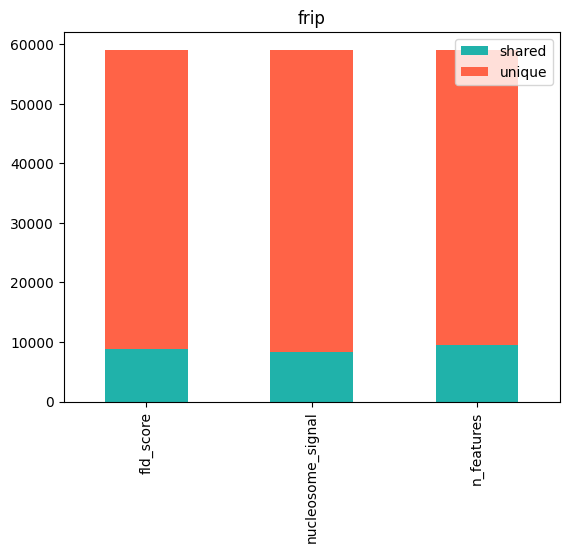

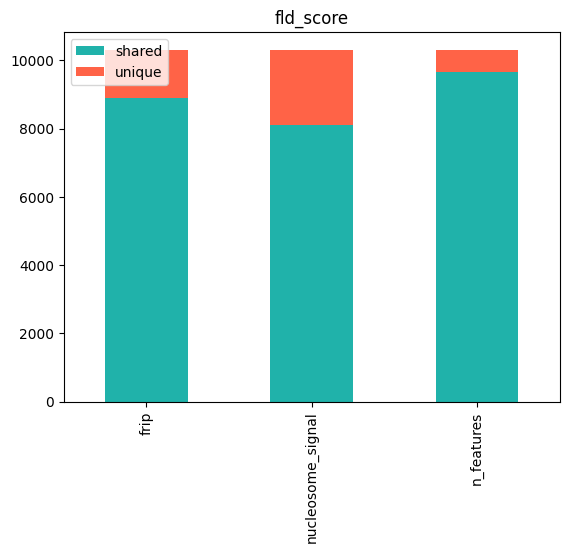

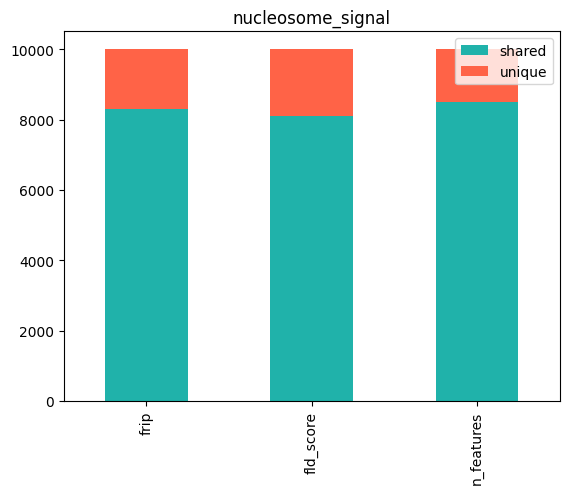

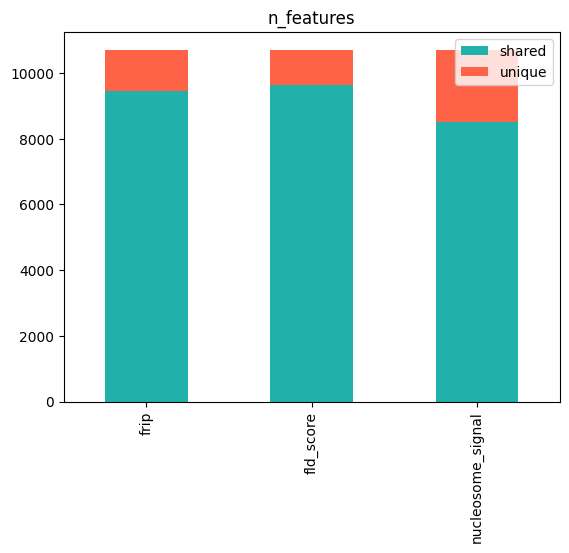

In [24]:
counts_df = pd.DataFrame(counts_histo)
color=['lightseagreen', 'tomato']

for column in counts_df:
    if not "+" in column:
        plot_dict = {}
        total = counts_df[column][column]

        for key, val in counts_df[column].items():
            if key != column:
                plot_dict[key] = {'shared' : total-val, 'unique':val}

        pd.DataFrame(plot_dict).T.plot(kind='bar', stacked=True, color=color, title=column)
        plt.show()

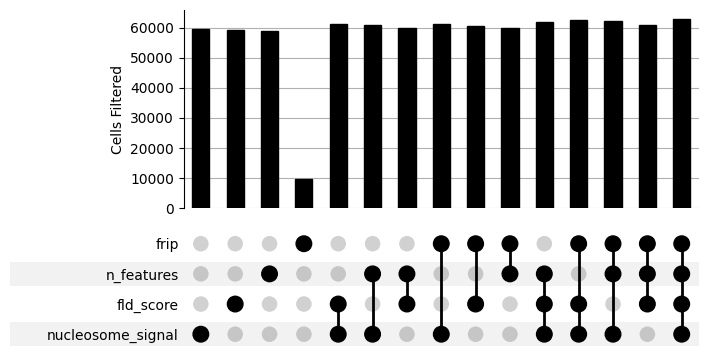

In [25]:
_, combinations_df_filtered = upset_plot_filter_impacts(adata, 
                                               thresholds=initial_thresholds, 
                                               groupby=groupby,
                                               limit_combinations=3,
                                               direction='filtered',
                                               log=False)

In [26]:
combinations_df_filtered

counts  \
n_features nucleosome_signal fld_score frip            
False      False             False     True     9701   
                             True      False   59155   
           True              False     False   59398   
True       False             False     False   58729   
False      False             True      True    60586   
           True              False     True    61096   
                             True      False   61305   
True       False             False     True    59992   
                             True      False   59805   
           True              False     False   60908   
False      True              True      True    62579   
True       False             True      True    60996   
           True              False     True    62054   
                             True      False   61691   
                                       True    62780   

                                                                                       barcodes  
n_features nucleosome_signal fld_score frip                                                      
False      False             False     True   Index(['AAACTACCAGAAACGGATCAGT', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
           True              False     False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
True       False             False     False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
False      False             True      True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
           True              False     True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
True       False             False     True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
           True              False     False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
False      True              True      True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
True       False             True      True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
           True              False     True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
                             True      False  Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...  
                                       True   Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...

In [27]:
combinations_df_filtered.index

MultiIndex([(False, False, False,  True),
            (False, False,  True, False),
            (False,  True, False, False),
            ( True, False, False, False),
            (False, False,  True,  True),
            (False,  True, False,  True),
            (False,  True,  True, False),
            ( True, False, False,  True),
            ( True, False,  True, False),
            ( True,  True, False, False),
            (False,  True,  True,  True),
            ( True, False,  True,  True),
            ( True,  True, False,  True),
            ( True,  True,  True, False),
            ( True,  True,  True,  True)],
           names=['n_features', 'nucleosome_signal', 'fld_score', 'frip'])

((True, True, True, False), counts                                                  61691
barcodes    Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...
Name: (True, True, True, False), dtype: object)
((True, True, False, True), counts                                                  62054
barcodes    Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...
Name: (True, True, False, True), dtype: object)
((True, False, True, True), counts                                                  60996
barcodes    Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...
Name: (True, False, True, True), dtype: object)
((False, True, True, True), counts                                                  62579
barcodes    Index(['AAACTACCAGAAACCCGAGATA', 'AAACTACCAGAA...
Name: (False, True, True, True), dtype: object)


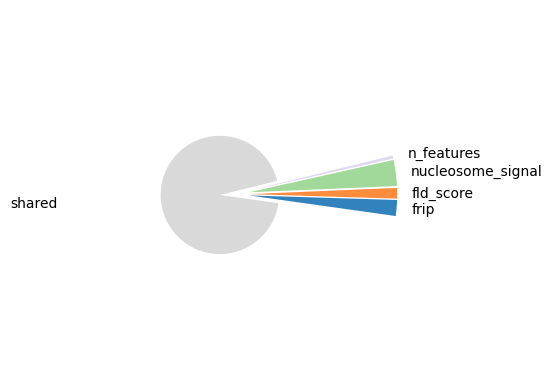

In [79]:
grades = np.sum(combinations_df_filtered.index.values.tolist(),axis=1)
comb_idx = np.where(grades == 3)[0]
counts_pie = {}

for row in combinations_df_filtered.iterrows():
    idx = row[1].name
    barcodes = set(row[1].barcodes)
    name = "+".join(np.array(combinations_df_filtered.index.names)[np.array(idx)])
    
    to_compare[name] = set(barcodes)

    for inner_row in combinations_df_filtered.iloc[comb_idx].iterrows():
        if not np.logical_and(row[0], inner_row[0]).any():
            print(inner_row)
            name_inner = "+".join(np.array(combinations_df_filtered.index.names)[np.array(inner_row[0])])
            barcodes_inner = set(inner_row[1].barcodes)
            unique_barcodes = barcodes-barcodes_inner
            counts_pie[name] = {'unique_counts':len(unique_barcodes), 'barcodes':unique_barcodes}
            #unique_barcodes_inner = barcodes_inner-barcodes
            #counts_pie[name_inner] = {'unique_counts':len(unique_barcodes_inner), 'barcodes':unique_barcodes_inner}


pie_df = pd.DataFrame(counts_pie).T   
all_uniques = pie_df['unique_counts'].sum()
all_unique_barcodes = set().union(*pie_df['barcodes'])
all_barcodes = set(np.concatenate(combinations_df_filtered['barcodes'].to_numpy()))
fully_shared_bc = all_barcodes - all_unique_barcodes
counts_pie['shared'] = {'unique_counts':len(fully_shared_bc), 'barcodes':fully_shared_bc}
pie_df = pd.DataFrame(counts_pie).T   

# Assuming 'sizes' and 'labels' are already defined from your pie_df:
labels = list(pie_df.index)
sizes = pie_df['unique_counts'].to_list()

# Index of the wedge you want to shrink (e.g., the largest wedge, index 0 in this case)
shrink_idx = np.argmax(sizes)

# Set up the colors
cmap = plt.colormaps['tab20c']
colors = cmap(np.linspace(0, 1, len(sizes)))

# Explode all other wedges except the shrunk one
explode = np.zeros(len(sizes))
explode[:] = 0.1  # Set an explosion value for all wedges

# Function to shrink the radius of a specific wedge
def modified_pie(ax, sizes, explode, shrink_idx, shrink_factor=0.4):
    wedges, texts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        explode=explode,
        startangle=-8
    )
    # Modify the radius of the target wedge
    wedges[shrink_idx].set_radius(shrink_factor)

    return wedges, texts

# Create figure and axis
fig, ax = plt.subplots()

# Apply the function
modified_pie(ax, sizes, explode, shrink_idx)
plt.savefig('overlaps-values.png', dpi=600)
plt.show()